# Analysis of iDM Events from LHE

In [1]:
import pylhe
import awkward as ak
import os

# need to "bind" the pylhe/vector/awkward classes together
# so we can access the vector helpers directly from awkward arrays
pylhe.register_awkward()

def _parquet_cache(lhe_fp) :
    """Determine the parquet cache file name by replacing the LHE extension"""
    return lhe_fp.replace(
        'lhe.gz' if lhe_fp.endswith('lhe.gz') else 'lhe',
        'parquet'
    )

def _from_pylhe(lhe_fp) :
    """read an LHE file into an awkward array in memory"""
    return pylhe.to_awkward(pylhe.read_lhe(lhe_fp))

def convert_to_parquet(lhe_fp) :
    """Convert the input LHE file into a parquet file of the same name and location
    but with the extension updated
    
    Converting the LHE file to a parquet file is beneficial because the resulting
    parquet file is about the same size as the gzipped LHE file but it offers about
    2 orders of magnitude speed up when reading the data back into an awkward array
    in memory.
        
    Parameters
    ----------
    lhe_fp : str
        path to LHE file to convert
    """
        
    ak.to_parquet(_from_pylhe(lhe_fp), _parquet_cache(lhe_fp))
    
def from_lhe(filepath, *, parquet_cache = True) :
    """Load an awkward array of the events in the passed LHE file
    
    Parameters
    ----------
    filepath : str
        Path to LHE file to load
    parquet_cache : bool, optional
        If true, use a parquet file alongside the LHE file to cache the parsing.
        This caching makes sure to update the cache if the LHE file timestamp is
        newer than the parquet cache timestamp. If false, never use a cache.
    """
    
    # need the file to exist
    if not os.path.exists(filepath) :
        raise ValueError(f'Input LHE file {filepath} does not exist.')

    # leave early without even thinking about cache if user doesn't want it
    if not parquet_cache :
        return _from_pylhe(filepath)
    
    # if cache doesn't exist or its last modification time is earlier than
    # the last modification time of the original LHE file, we need to create
    # the cache file
    cache_fp = _parquet_cache(filepath)
    if not os.path.exists(cache_fp) or os.path.getmtime(cache_fp) < os.path.getmtime(filepath) :
        convert_to_parquet(filepath)
    
    # load the data from the cache
    return ak.from_parquet(cache_fp)

## Analysis
Parse in the awkward array with `ak.from_parquet` and then begin filling histograms.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import mplhep
plt.style.use(mplhep.style.ROOT)

import numpy as np
import hist

## Lowering $m_\chi$
Walking $m_\chi$ lower, validating that the resulting data has changed mass values. The goal here is to make sure the internal model implementation doesn't have restrictions on the absolute value of this parameter.

The main requirement we have is $m_\chi > \Delta m_\chi$ so that the lower mass $m_{\chi_1}$ is still positive.

In [7]:
opts = [
    (r'$m_\chi = 1$ GeV', ak.unzip(from_lhe('../MG5_aMC_v3_4_1/me-packs/idm-0-no-restrict/Events/run_01/unweighted_events.lhe.gz'))),
    (r'$m_\chi = 0.1$ GeV', ak.unzip(from_lhe('../MG5_aMC_v3_4_1/me-packs/idm-1-no-restrict/Events/run_01/unweighted_events.lhe'))),
    (r'$m_\chi = 0.02$ GeV', ak.unzip(from_lhe('../MG5_aMC_v3_4_1/me-packs/idm-1-no-restrict/Events/run_02/unweighted_events.lhe'))),
    (r'$m_\chi = 0.1$ GeV', ak.unzip(from_lhe('../MG5_aMC_v3_4_1/me-packs/idm-6-no-zpn-coupling/Events/run_01/unweighted_events.lhe.gz'))),
]

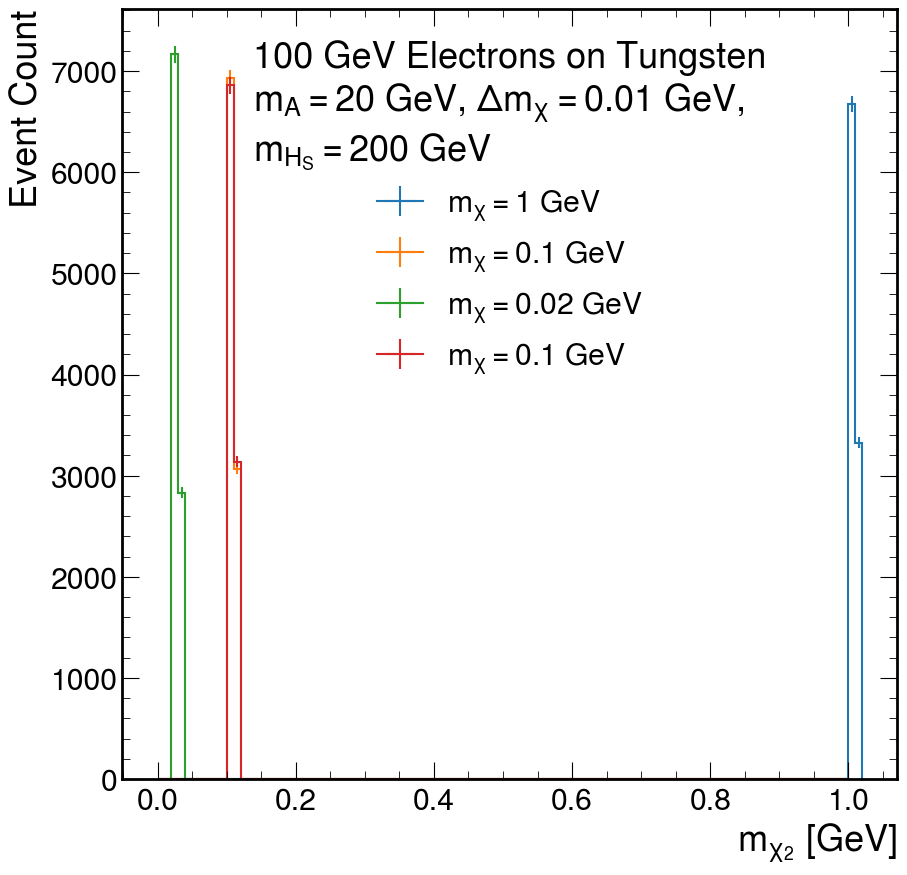

In [8]:
for name, (eventinfo, particles) in opts :
    hist.Hist(hist.axis.Regular(bins=100,start=0,stop=1,growth=True)).fill(
        ak.flatten(particles[(particles['id']==1000023)]['m'])
    ).plot(label=name)
plt.xlabel('$m_{\chi_2}$ [GeV]')
plt.ylabel('Event Count')
plt.legend(title="""100 GeV Electrons on Tungsten
$m_A = 20$ GeV, $\Delta m_\chi = 0.01$ GeV, 
$m_{H_S} = 200$ GeV""")
plt.show()

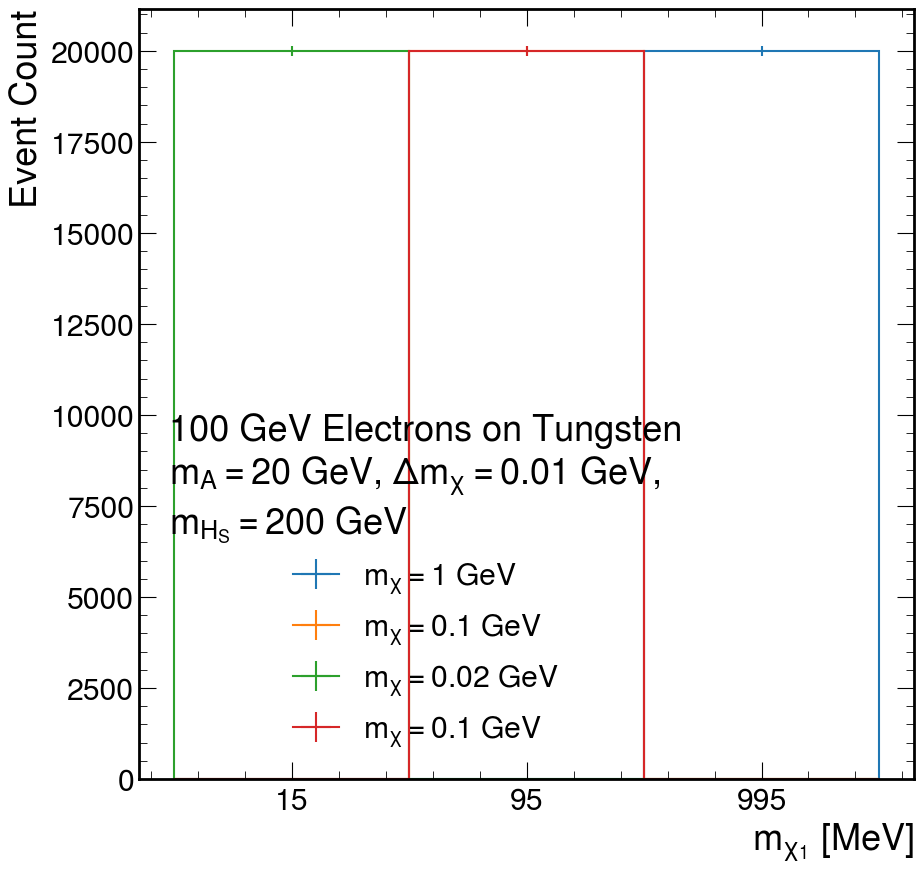

In [9]:
for name, (event_info, particles) in opts :
    h = hist.Hist(hist.axis.IntCategory([20-5,100-5,1000-5]))
    h.fill(ak.to_numpy(ak.flatten(particles[(particles['id']==1000022)]['m']*1000)).astype(int))
    h.plot(label=name)
plt.xlabel('$m_{\chi_1}$ [MeV]')
plt.ylabel('Event Count')
plt.legend(title="""100 GeV Electrons on Tungsten
$m_A = 20$ GeV, $\Delta m_\chi = 0.01$ GeV, 
$m_{H_S} = 200$ GeV""")
plt.show()

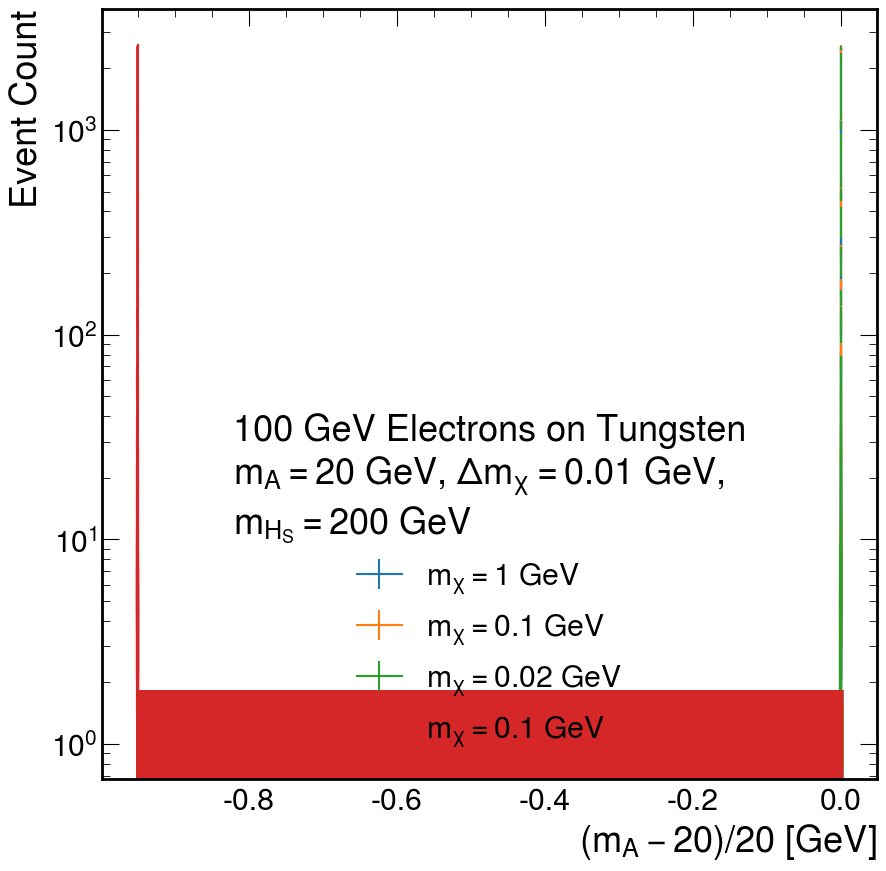

In [10]:
for name, (event_info, particles) in opts :
    h = hist.Hist(hist.axis.Regular(bins=100,start=-1e-3,stop=+1e-3,growth=True))
    h.fill(ak.flatten((particles[(particles['id']==1023)]['m']-20))/20)
    h.plot(label=name)
plt.xlabel('$(m_{A}-20)/20$ [GeV]')
plt.ylabel('Event Count')
plt.yscale('log')
plt.legend(title="""100 GeV Electrons on Tungsten
$m_A = 20$ GeV, $\Delta m_\chi = 0.01$ GeV, 
$m_{H_S} = 200$ GeV""")
plt.show()

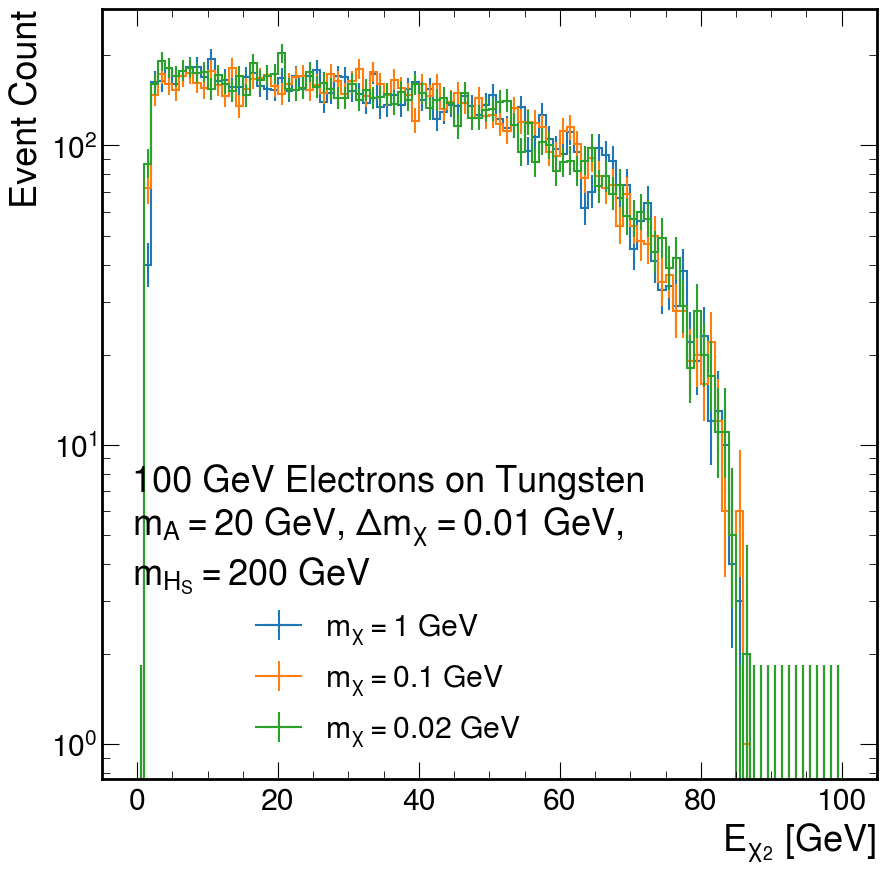

In [12]:
for name, (event_info, particles) in opts :
    h = hist.Hist(hist.axis.Regular(bins=100,start=0,stop=100,growth=True))
    h.fill(ak.flatten(particles[(particles['id']==1000023)]['vector']['t']))
    h.plot(label=name)
plt.xlabel('$E_{\chi_2}$ [GeV]')
plt.ylabel('Event Count')
plt.yscale('log')
plt.legend(title="""100 GeV Electrons on Tungsten
$m_A = 20$ GeV, $\Delta m_\chi = 0.01$ GeV, 
$m_{H_S} = 200$ GeV""")
plt.show()

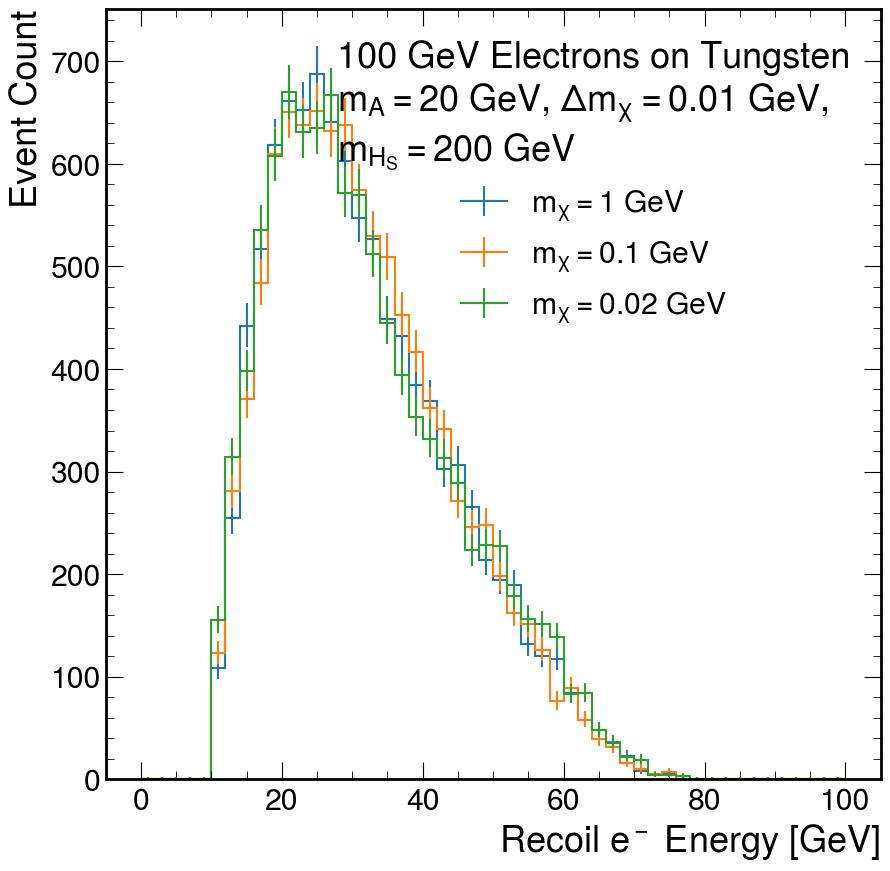

In [13]:
for name, (event_info, particles) in opts :
    h = hist.Hist(hist.axis.Regular(bins=50, start=0, stop=100, name='Recoil Electron Energy [GeV]'))
    h.fill(
        ak.flatten(
            particles[(particles['id']==+11)&(particles['status']==1)&(particles['mother2']==2)]['vector']['t']
        )
    )
    h.plot(label=name)
plt.xlabel('Recoil $e^-$ Energy [GeV]')
plt.ylabel('Event Count')
plt.legend(title="""100 GeV Electrons on Tungsten
$m_A = 20$ GeV, $\Delta m_\chi = 0.01$ GeV, 
$m_{H_S} = 200$ GeV""")
plt.savefig('idm-recoil-electron-energy.pdf', bbox_inches='tight')
plt.show()

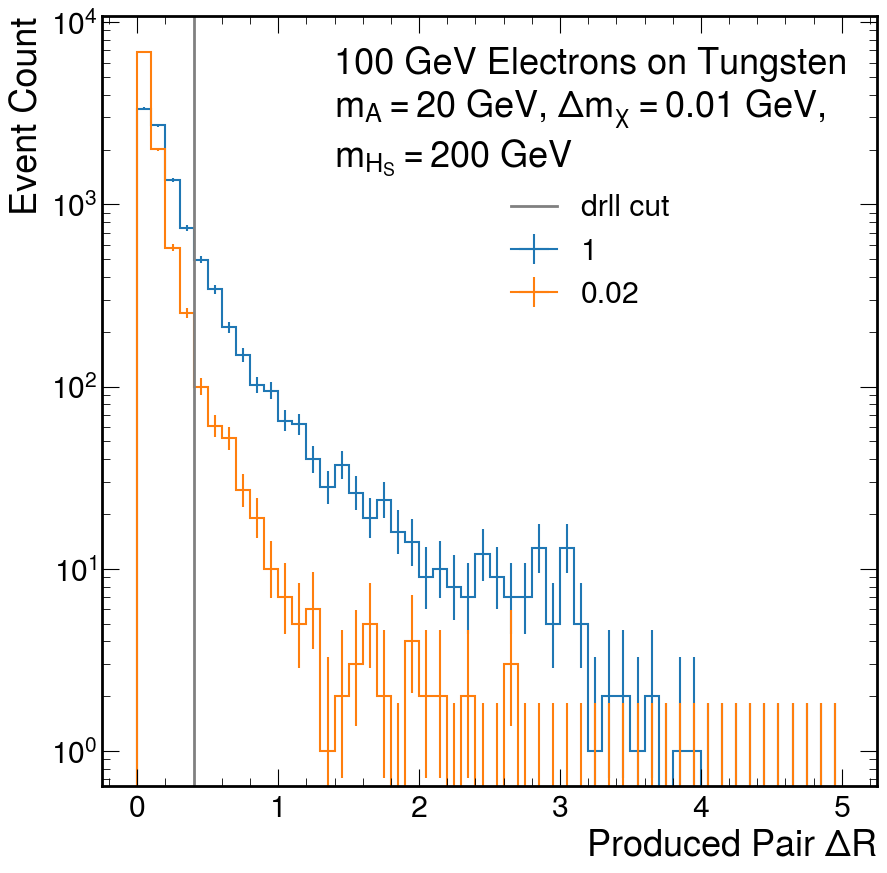

In [112]:
for name, (event_info, particles) in opts :
    h = hist.Hist(hist.axis.Regular(bins=50, start=0, stop=5))
    prod_pos = ak.flatten(particles[(particles['id']==+11)&(particles['status']>0)&(particles['mother2']>2)]['vector'])
    prod_ele = ak.flatten(particles[(particles['id']==-11)&(particles['status']>0)&(particles['mother2']>2)]['vector'])
    h.fill(prod_pos.deltaR(prod_ele))
    h.plot(label=name)
plt.xlabel(f'Produced Pair $\Delta R$')
plt.ylabel('Event Count')
plt.yscale('log')
plt.axvline(0.4, color='gray', lw=2, label='drll cut')
plt.legend(title="""100 GeV Electrons on Tungsten
$m_A = 20$ GeV, $\Delta m_\chi = 0.01$ GeV, 
$m_{H_S} = 200$ GeV""")
#plt.savefig(f'idm-produced-{p.lower()}-energy.pdf', bbox_inches='tight')
plt.show()

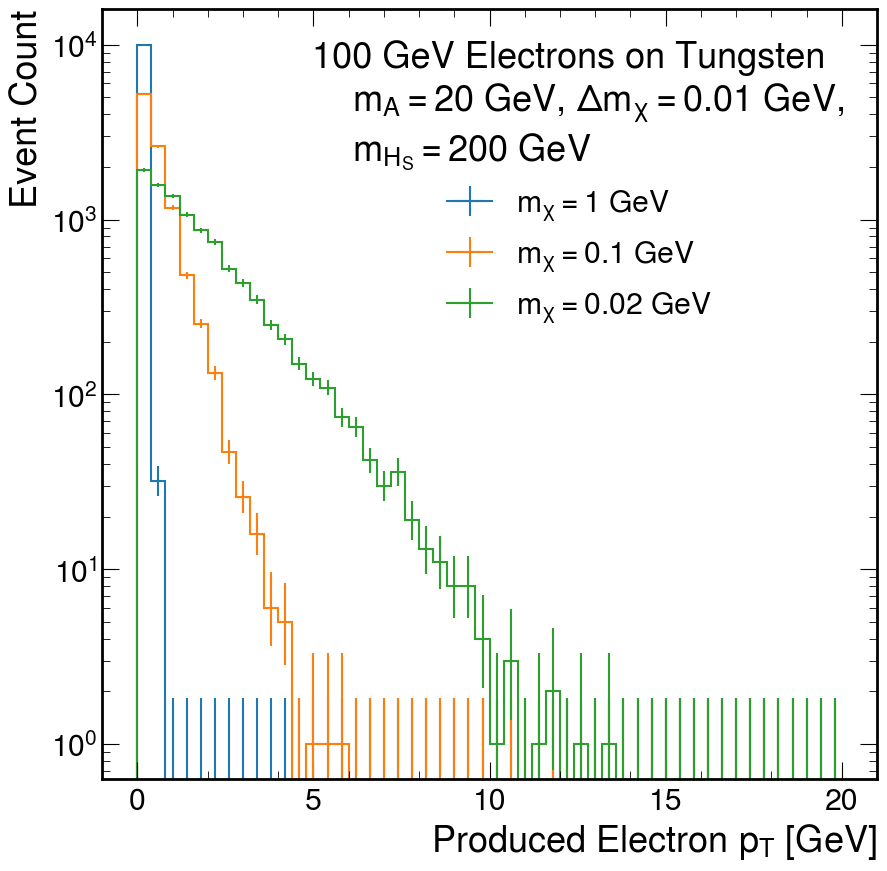

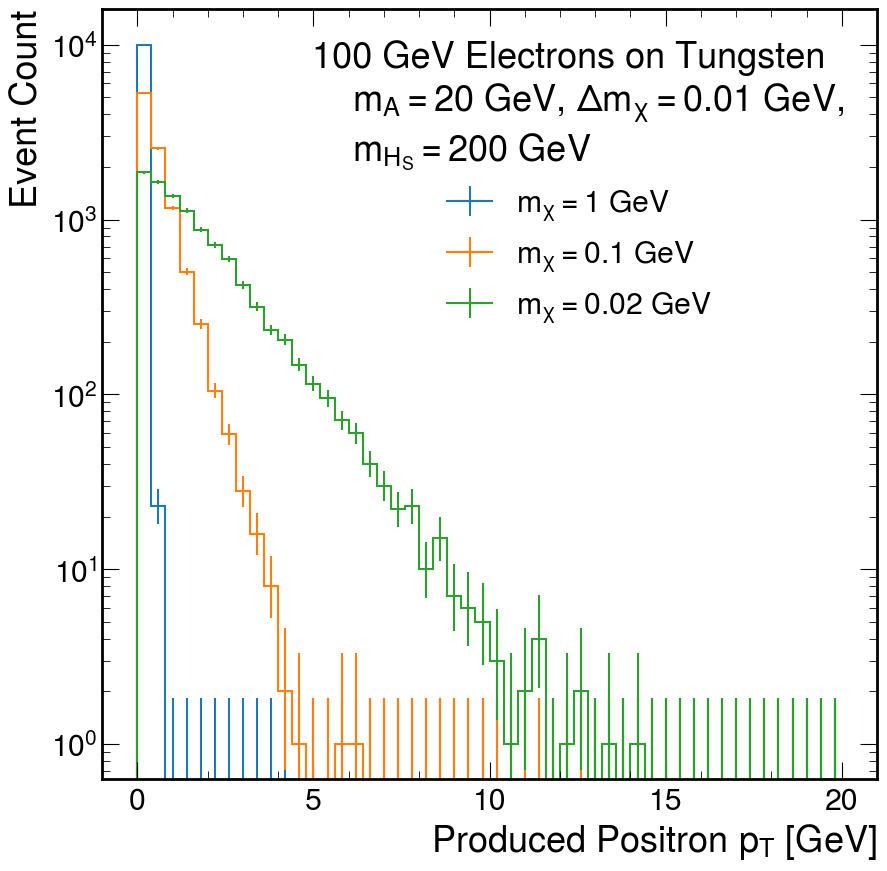

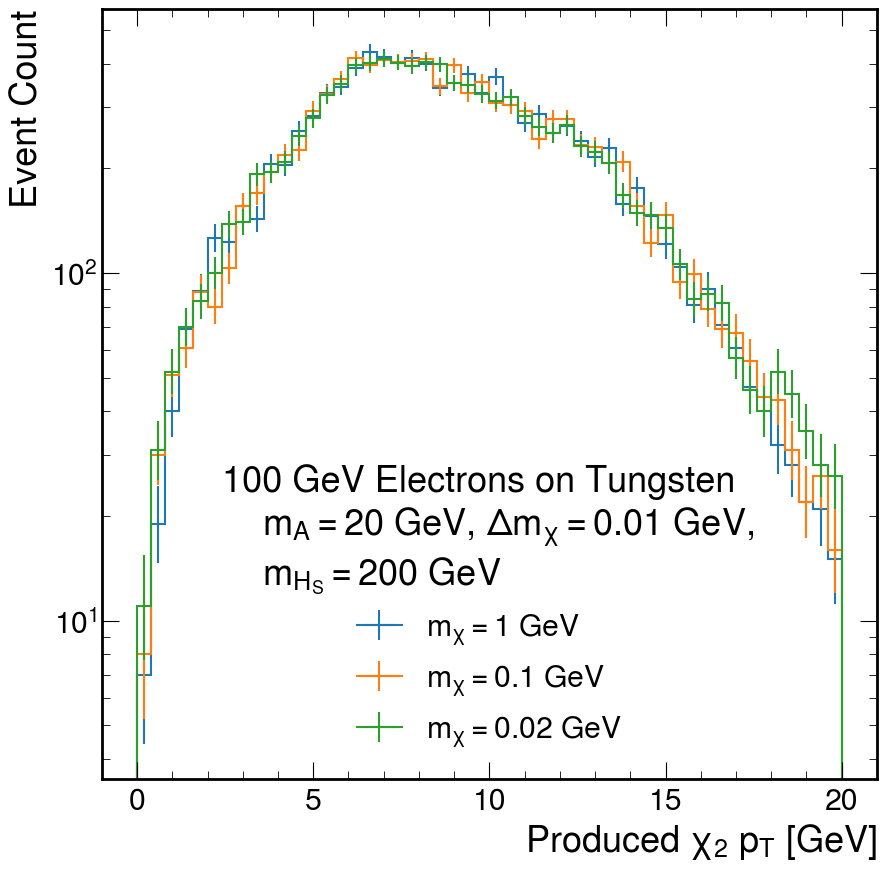

In [56]:
for p, pdg in [('Electron',11),('Positron',-11),(r'$\chi_2$',1000023)] :
    for name, (event_info, particles) in opts :
        h = hist.Hist(hist.axis.Regular(bins=50, start=0, stop=20, name=f'Produced {p} Energy [GeV]'))
        momentum = particles[(particles['id']==pdg)&(particles['status']>0)&(particles['mother2']>2)]['vector']
        h.fill(
            ak.flatten(momentum['x']**2 + momentum['y']**2)**0.5
        )
        h.plot(label=name)
    plt.xlabel(f'Produced {p} $p_T$ [GeV]')
    plt.ylabel('Event Count')
    plt.yscale('log')
    plt.legend(title="""100 GeV Electrons on Tungsten
    $m_A = 20$ GeV, $\Delta m_\chi = 0.01$ GeV, 
    $m_{H_S} = 200$ GeV""")
    #plt.savefig(f'idm-produced-{p.lower()}-energy.pdf', bbox_inches='tight')
    plt.show()

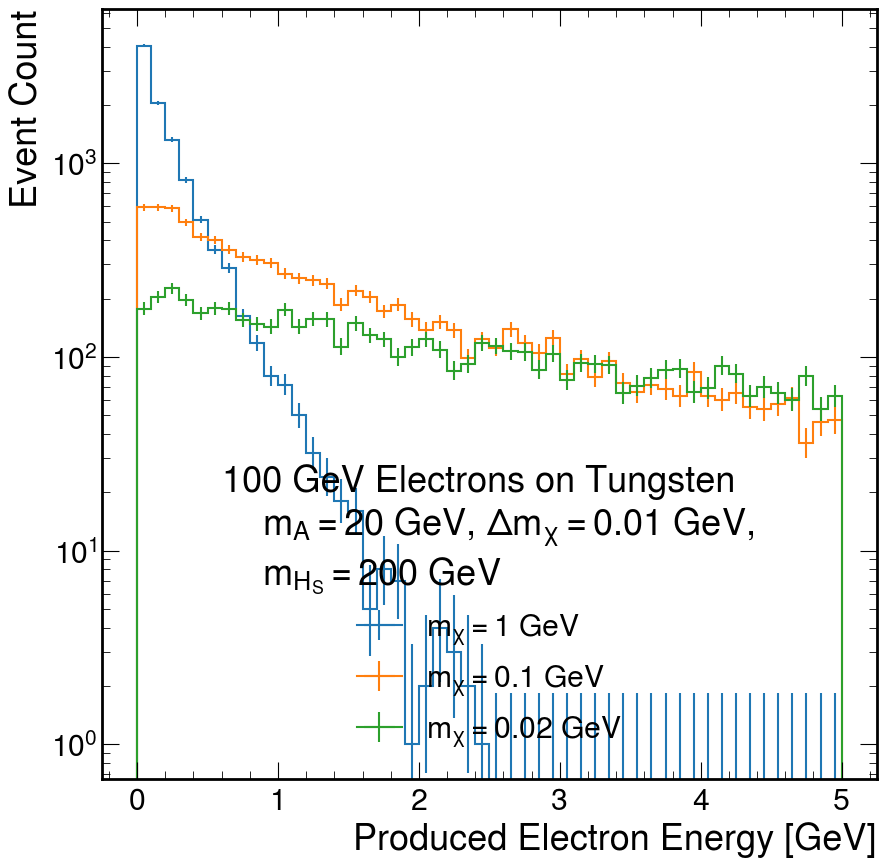

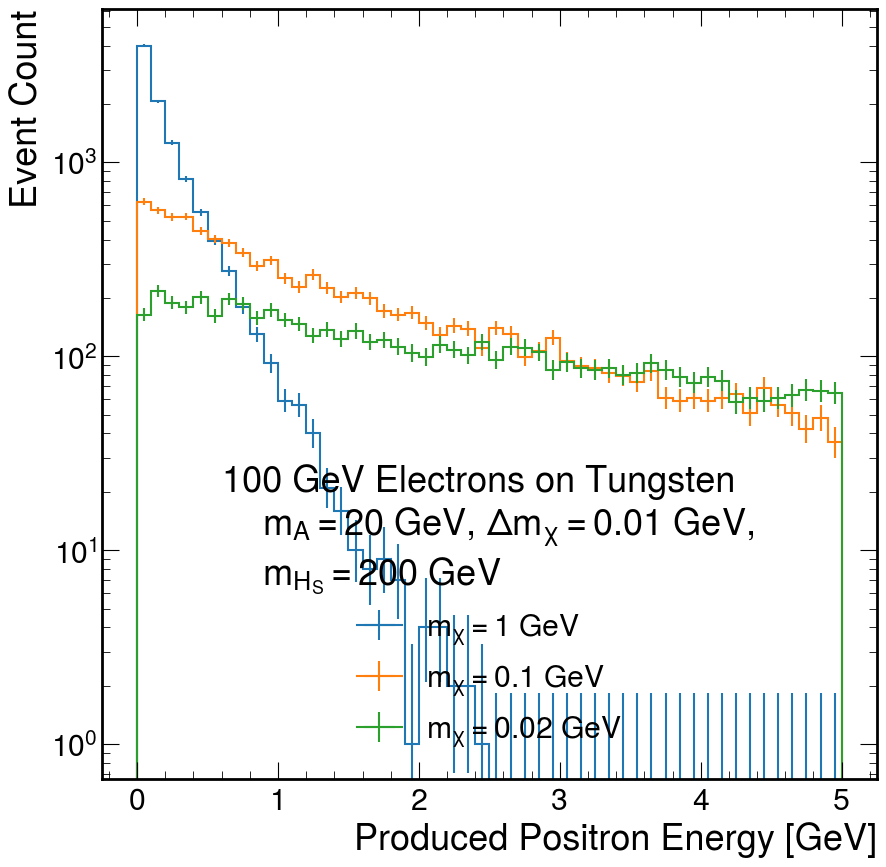

In [14]:
for p, pdg in [('Electron',11),('Positron',-11)] :
    for name, (event_info, particles) in opts :
        h = hist.Hist(hist.axis.Regular(bins=50, start=0, stop=5, name=f'Produced {p} Energy [GeV]'))
        h.fill(
            ak.flatten(
                particles[(particles['id']==pdg)&(particles['status']==1)&(particles['mother2']>2)]['vector']['t']
            )
        )
        h.plot(label=name)
    plt.xlabel(f'Produced {p} Energy [GeV]')
    plt.ylabel('Event Count')
    plt.yscale('log')
    plt.legend(title="""100 GeV Electrons on Tungsten
    $m_A = 20$ GeV, $\Delta m_\chi = 0.01$ GeV, 
    $m_{H_S} = 200$ GeV""")
    #plt.savefig(f'idm-produced-{p.lower()}-energy.pdf', bbox_inches='tight')
    plt.show()

## Lowering $m_A$
We also need to lower the dark photon mass so it is accessible by the HPS beam energy.

The main requirement is $m_A > 2 m_\chi$ so that the dark photon can still decay to $\chi_1 \chi_2$.

Lowering the dark photon to 2 GeV from 20 GeV immediately cut out phase space. Even with the beam energy at 100 GeV, MG only reported 2 events out of the 10k requested.

In [32]:
# m_chi = 0.02 GeV, Delta m_chi = 0.01 GeV
opts = [
    (20, ak.unzip(from_lhe('../MG5_aMC_v3_4_1/me-packs/idm-1-no-restrict/Events/run_02/unweighted_events.lhe.gz'))),
    (2, ak.unzip(from_lhe('../MG5_aMC_v3_4_1/me-packs/idm-1-no-restrict/Events/run_03/unweighted_events.lhe.gz'))),
]

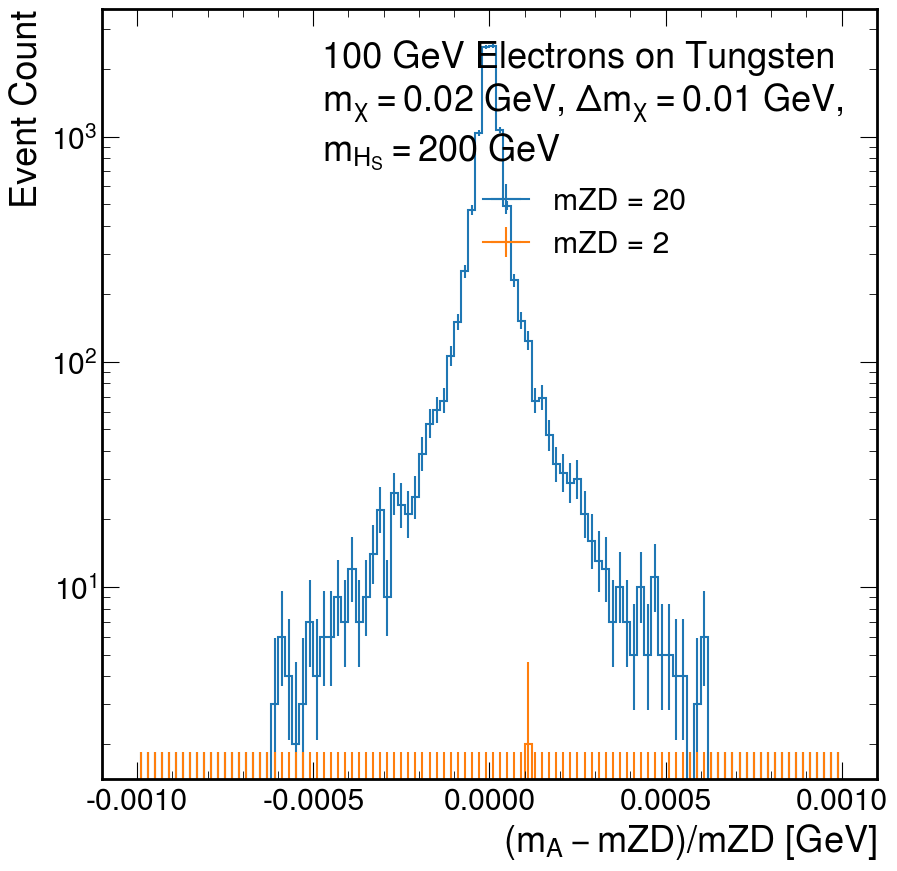

In [33]:
for mZD, (event_info, particles) in opts :
    h = hist.Hist(hist.axis.Regular(bins=100,start=-1e-3,stop=+1e-3,growth=True))
    h.fill(ak.flatten((particles[(particles['id']==1023)]['m']-mZD)/mZD))
    h.plot(label=f'mZD = {mZD}')
plt.xlabel('$(m_{A} - mZD)/mZD$ [GeV]')
plt.ylabel('Event Count')
plt.yscale('log')
plt.legend(title="""100 GeV Electrons on Tungsten
$m_\chi = 0.02$ GeV, $\Delta m_\chi = 0.01$ GeV, 
$m_{H_S} = 200$ GeV""")
plt.show()

## Lowering $m_{H_S}$
Since lowering `mZD` by itself seemed to close the phase space accessible, I am going to try to lower the other mass parameter `mHS` or what I understand as the mass of the dark higgs. Previously, it was left at 200 GeV but since `mZD` went down by an order of magnitude, I am going to try a run with `mHS` at 20.

In [39]:
# m_chi = 0.02 GeV, Delta m_chi = 0.01 GeV
opts = [
    ((20,200), ak.unzip(from_lhe('../MG5_aMC_v3_4_1/me-packs/idm-1-no-restrict/Events/run_02/unweighted_events.lhe.gz'))),
    ((2,20), ak.unzip(from_lhe('../MG5_aMC_v3_4_1/me-packs/idm-1-no-restrict/Events/run_04/unweighted_events.lhe.gz'))),
    ((2,10), ak.unzip(from_lhe('../MG5_aMC_v3_4_1/me-packs/idm-1-no-restrict/Events/run_05/unweighted_events.lhe.gz'))),
]

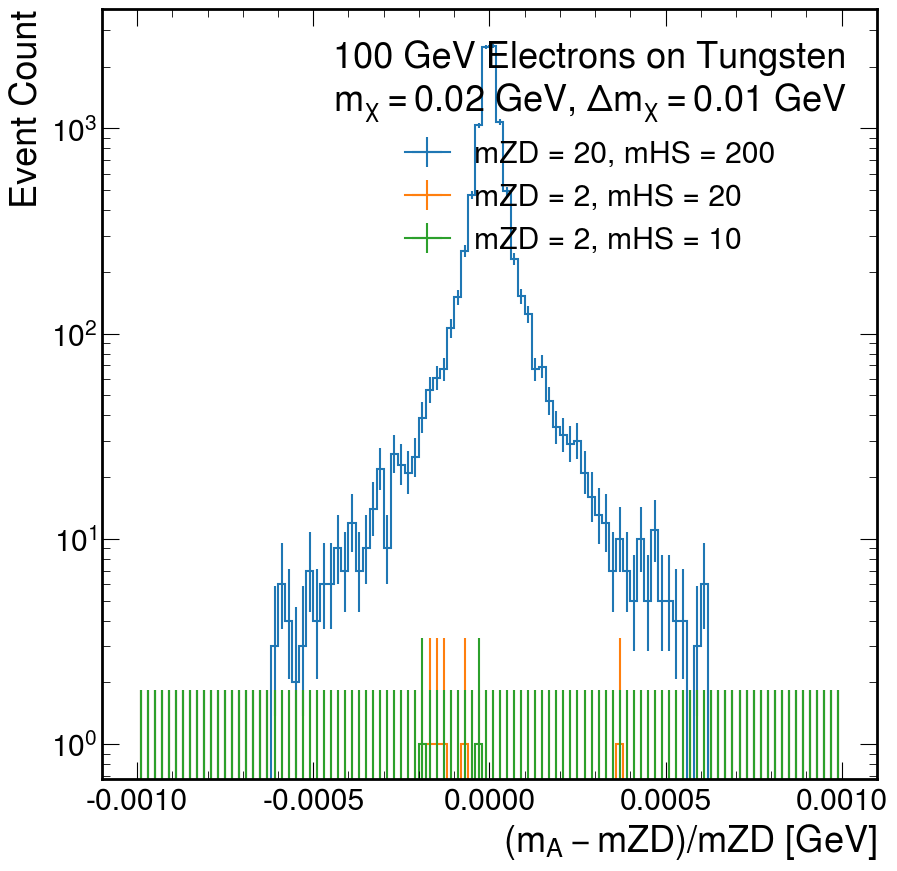

In [40]:
for (mZD,mHS), (event_info, particles) in opts :
    h = hist.Hist(hist.axis.Regular(bins=100,start=-1e-3,stop=+1e-3,growth=True))
    h.fill(ak.flatten((particles[(particles['id']==1023)]['m']-mZD)/mZD))
    h.plot(label=f'mZD = {mZD}, mHS = {mHS}')
plt.xlabel('$(m_{A} - mZD)/mZD$ [GeV]')
plt.ylabel('Event Count')
plt.yscale('log')
plt.legend(title="""100 GeV Electrons on Tungsten
$m_\chi = 0.02$ GeV, $\Delta m_\chi = 0.01$ GeV""")
plt.show()

## Changing `kap`

Try lowering `kap` as well but also try raising it since I think it is proportional to an interaction strength and we need to make the interaction stronger if we are running out of phase space.

In [45]:
# m_chi = 0.02 GeV, Delta m_chi = 0.01 GeV
opts = [
    ((20,200,1e-9), ak.unzip(from_lhe('../MG5_aMC_v3_4_1/me-packs/idm-1-no-restrict/Events/run_02/unweighted_events.lhe.gz'))),
    ((2,10,1e-11), ak.unzip(from_lhe('../MG5_aMC_v3_4_1/me-packs/idm-1-no-restrict/Events/run_06/unweighted_events.lhe.gz'))),
    ((2,10,1e-7), ak.unzip(from_lhe('../MG5_aMC_v3_4_1/me-packs/idm-1-no-restrict/Events/run_07/unweighted_events.lhe.gz'))),
]

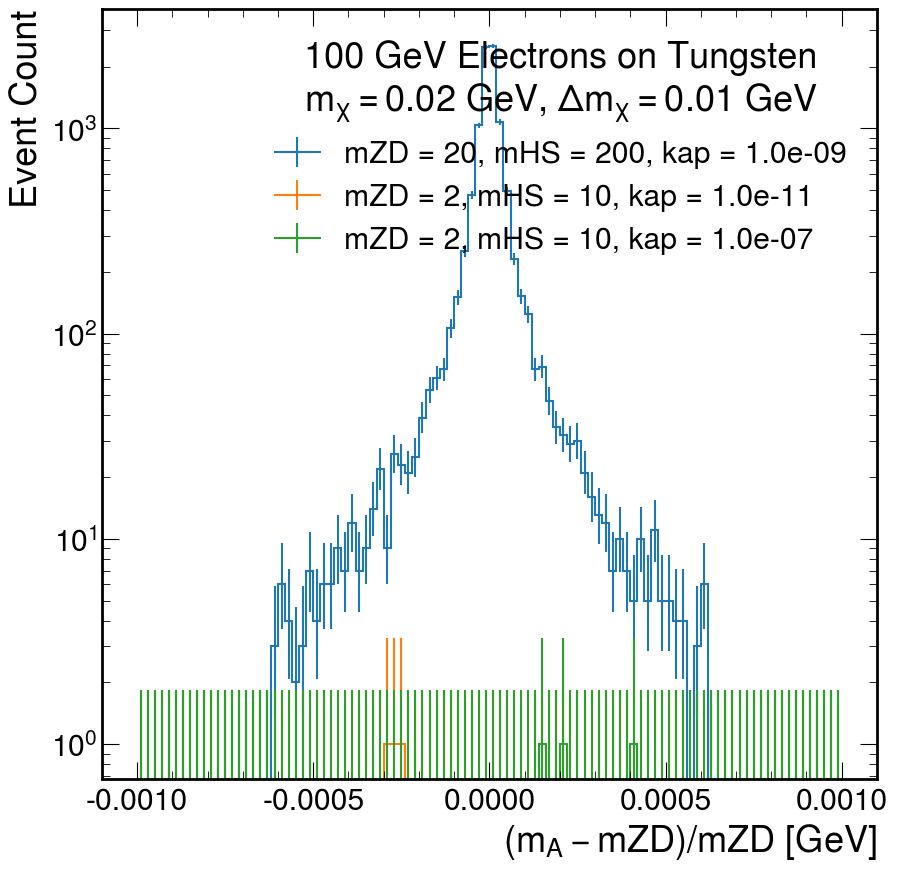

In [46]:
for (mZD,mHS,kap), (event_info, particles) in opts :
    h = hist.Hist(hist.axis.Regular(bins=100,start=-1e-3,stop=+1e-3,growth=True))
    h.fill(ak.flatten((particles[(particles['id']==1023)]['m']-mZD)/mZD))
    h.plot(label=f'mZD = {mZD}, mHS = {mHS}, kap = {kap:.1e}')
plt.xlabel('$(m_{A} - mZD)/mZD$ [GeV]')
plt.ylabel('Event Count')
plt.yscale('log')
plt.legend(title="""100 GeV Electrons on Tungsten
$m_\chi = 0.02$ GeV, $\Delta m_\chi = 0.01$ GeV""")
plt.show()

# Feedback from Ana Workshop
- Look for cut (looks like $E_{\chi_2}$ has a min energy cut)
- Lower `mZD` more to match ratio from defaults
- Lower `dMchi` more to match ratio from defaults

### Looking for Cuts
There are a lot of cuts in the default `run_card.dat` that I can remove one-by-one.
The following lists the run number and the cut removed relative `run_05`.

8. Set all listed minimums to `0.0` and listed maximums to `-1.0` (i.e. no cuts) => 10k events
    - I think, it is difficult to verify since the cuts listed in the header are the same as all previous runs ?!?
9. Remove `drll` minimum of `0.4`
10. 

In [22]:
opts = [
    ((1, 20, 200, 100), ak.unzip(from_lhe('../MG5_aMC_v3_4_1/me-packs/idm-0-no-restrict/Events/run_01/unweighted_events.lhe.gz'))),
    ((0.02, 2, 10, 100), ak.unzip(from_lhe('../MG5_aMC_v3_4_1/me-packs/idm-1-no-restrict/Events/run_08/unweighted_events.lhe'))),
    ((0.1, 1, 200, 2.3), ak.unzip(from_lhe('../MG5_aMC_v3_4_1/me-packs/idm-6-no-zpn-coupling/Events/run_01/unweighted_events.lhe.gz'))),
]

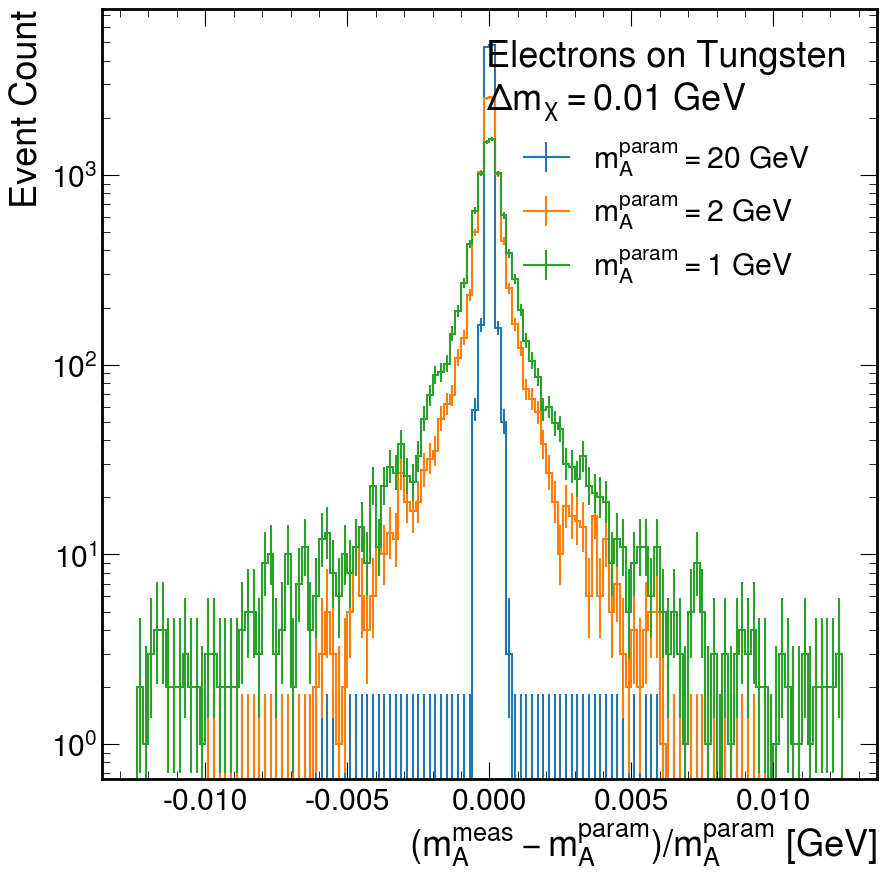

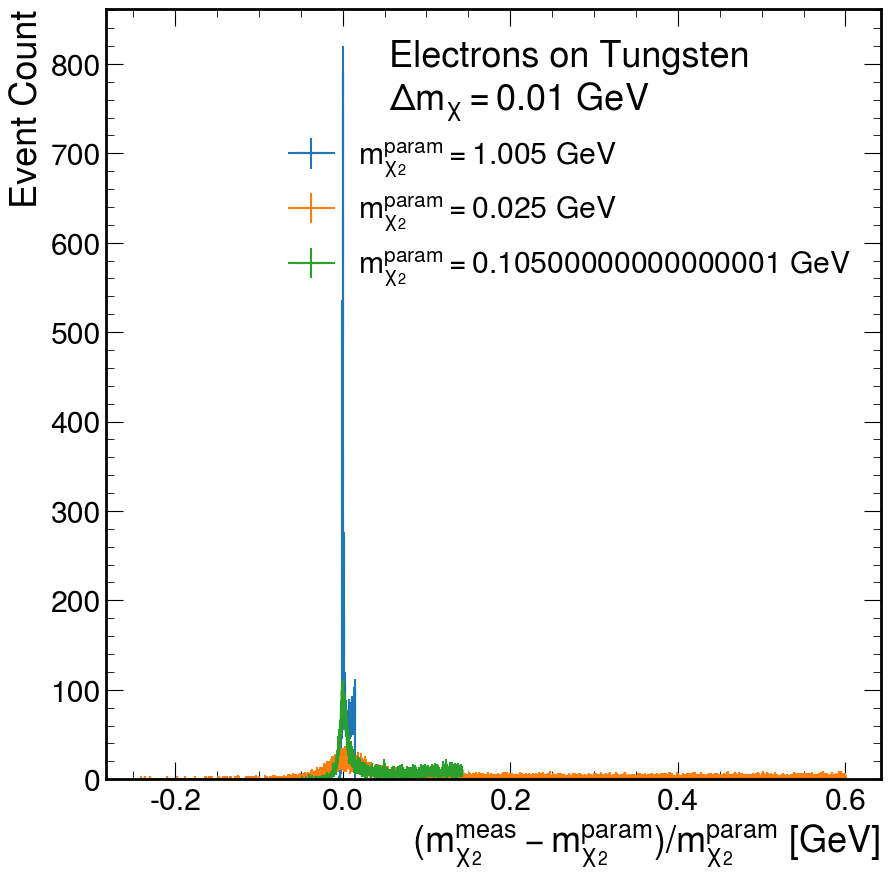

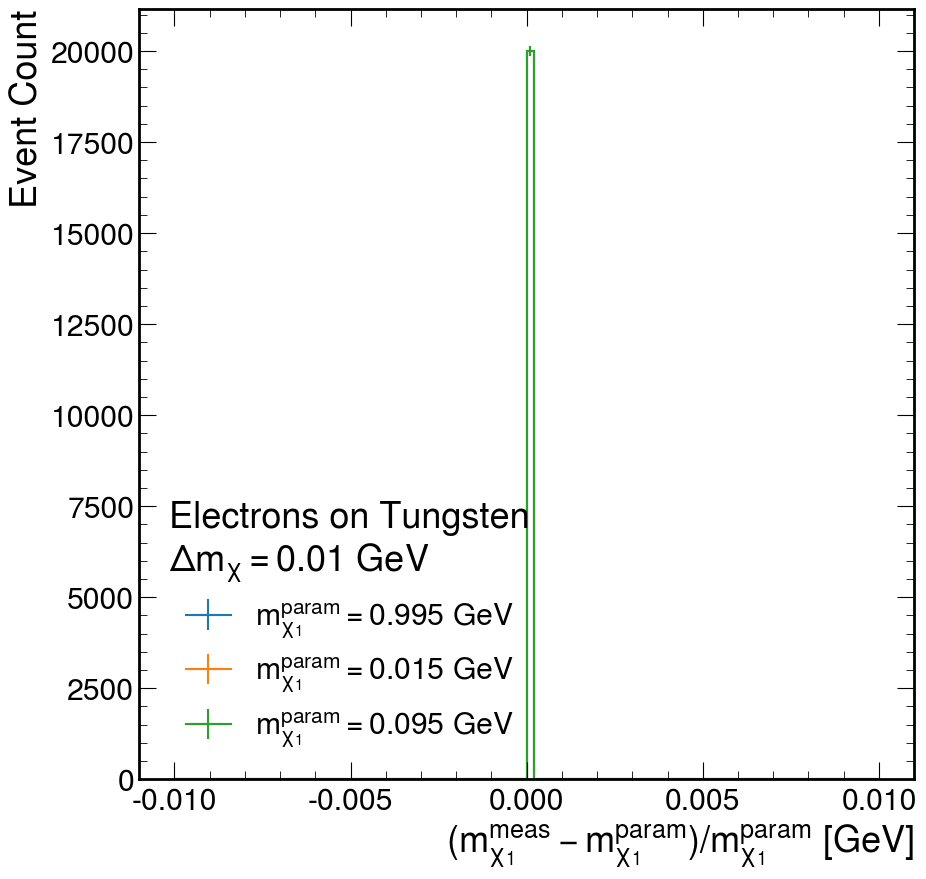

In [23]:
for (mC, mZ, mH, ebeam), (event_info, particles) in opts :
    h = hist.Hist(hist.axis.Regular(bins=100,start=-1e-2,stop=+1e-2,growth=True))
    h.fill(ak.flatten((particles[(particles['id']==1023)]['m']-mZ)/mZ))
    h.plot(label='$m^{param}_{A} = '+f'{mZ}$ GeV')
plt.xlabel('$(m^{meas}_{A} - m^{param}_{A})/m^{param}_{A}$ [GeV]')
plt.ylabel('Event Count')
plt.yscale('log')
plt.legend(title="""Electrons on Tungsten
$\Delta m_\chi = 0.01$ GeV""")
plt.show()

for (mC,mZ,mH,ebeam), (eventinfo, particles) in opts :
    param = (mC + 0.5 * 0.01)
    hist.Hist(hist.axis.Regular(bins=100,start=-1e-2,stop=1e-2,growth=True)).fill(
        ak.flatten((particles[(particles['id']==1000023)]['m']-param)/param)
    ).plot(label='$m^{param}_{\chi_2} = '+f'{param}$ GeV')
plt.xlabel('$(m^{meas}_{\chi_2} - m_{\chi_2}^{param})/m_{\chi_2}^{param}$ [GeV]')
plt.ylabel('Event Count')
plt.legend(title="""Electrons on Tungsten
$\Delta m_\chi = 0.01$ GeV""")
plt.show()

for (mC,mZ,mH,ebeam), (eventinfo, particles) in opts :
    param = (mC - 0.5 * 0.01)
    hist.Hist(hist.axis.Regular(bins=100,start=-1e-2,stop=1e-2,growth=True)).fill(
        ak.flatten((particles[(particles['id']==1000022)]['m']-param)/param)
    ).plot(label='$m^{param}_{\chi_1} = '+f'{param}$ GeV')
plt.xlabel('$(m^{meas}_{\chi_1} - m_{\chi_1}^{param})/m_{\chi_1}^{param}$ [GeV]')
plt.ylabel('Event Count')
plt.legend(title="""Electrons on Tungsten
$\Delta m_\chi = 0.01$ GeV""")
plt.show()

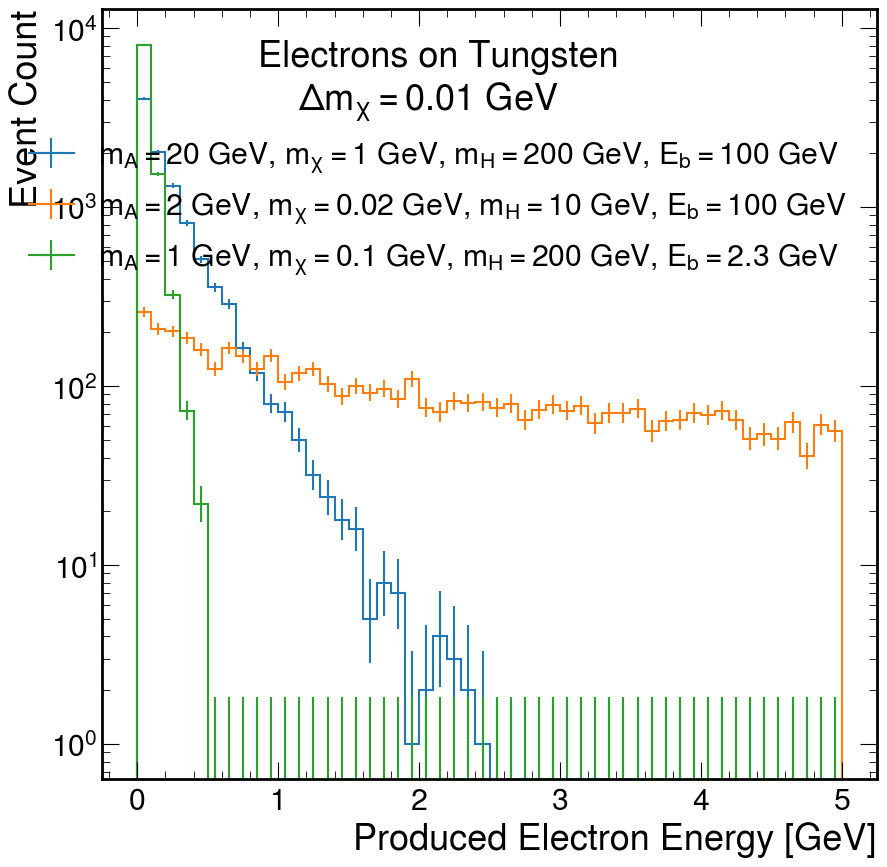

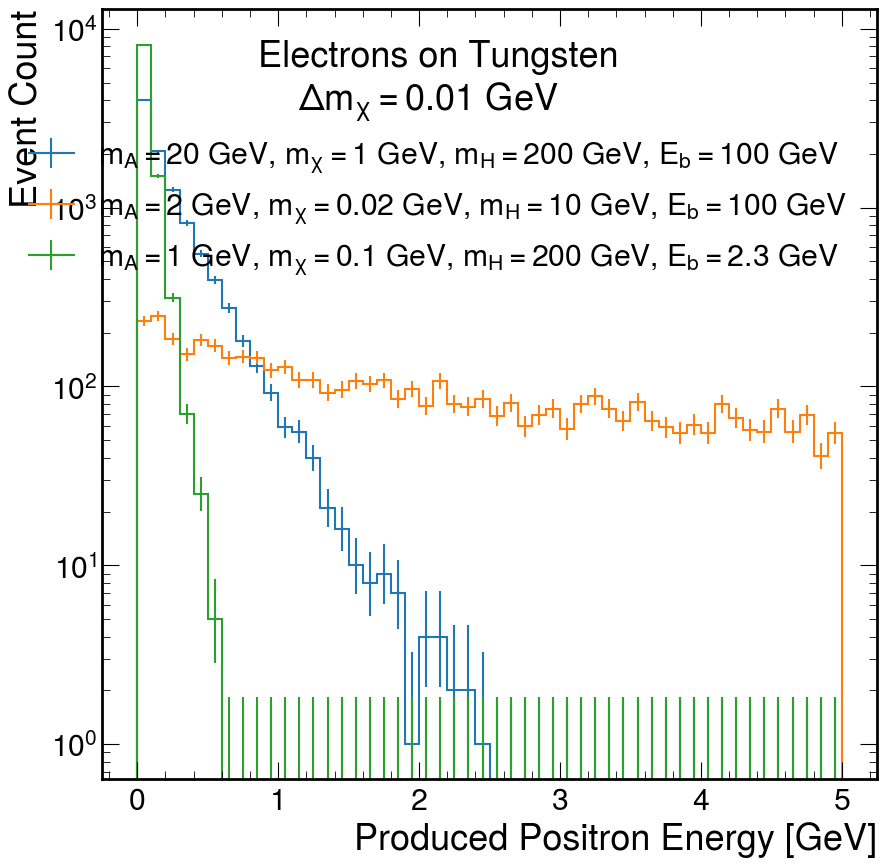

In [24]:
for p, pdg in [('Electron',11),('Positron',-11)] :
    for (mC, mZ, mH, ebeam), (event_info, particles) in opts :
        h = hist.Hist(hist.axis.Regular(bins=50, start=0, stop=5, name=f'Produced {p} Energy [GeV]'))
        h.fill(
            ak.flatten(
                particles[(particles['id']==pdg)&(particles['status']==1)&(particles['mother2']>2)]['vector']['t']
            )
        )
        h.plot(label=f'$m_A = {mZ}$ GeV, $m_\chi = {mC}$ GeV, $m_H = {mH}$ GeV, $E_b = {ebeam}$ GeV')
    plt.xlabel(f'Produced {p} Energy [GeV]')
    plt.ylabel('Event Count')
    plt.yscale('log')
    plt.legend(title="""Electrons on Tungsten
    $\Delta m_\chi = 0.01$ GeV""")
    #plt.savefig(f'idm-produced-{p.lower()}-energy.pdf', bbox_inches='tight')
    plt.show()

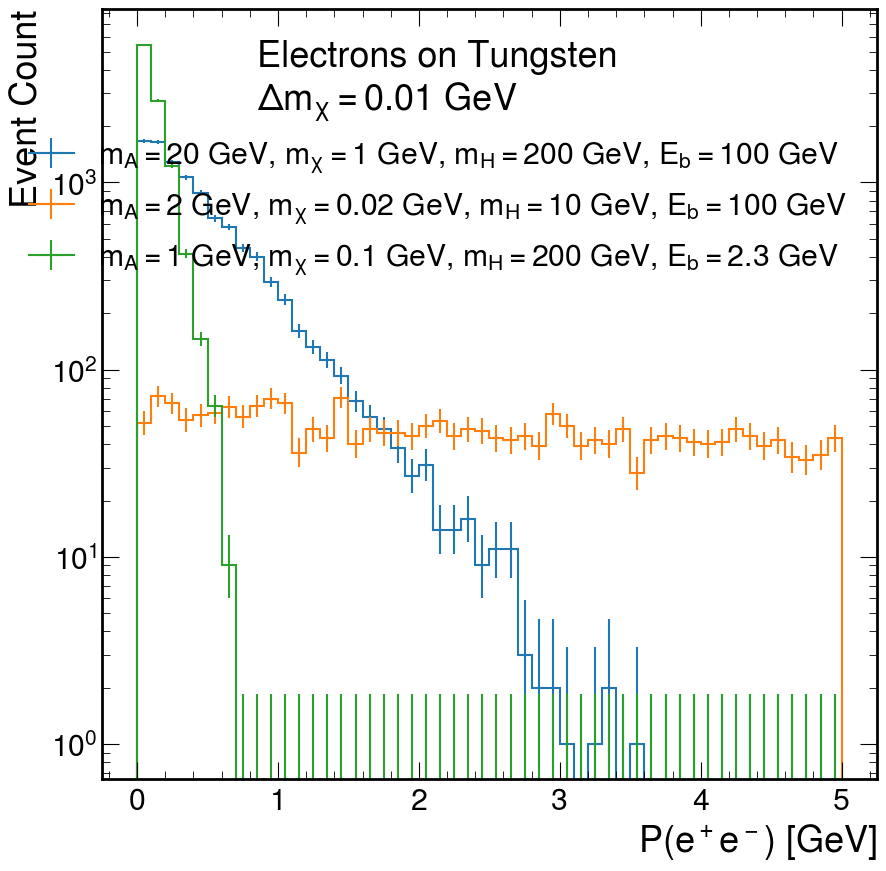

In [26]:
for (mC, mZ, mH, ebeam), (event_info, particles) in opts :
    hist.Hist(hist.axis.Regular(bins=50, start=0, stop=5, name='Esum')).fill(
        ak.flatten(
            particles[(particles['id']==-11)&(particles['status']==1)&(particles['mother2']>2)]['vector']['t']
            + particles[(particles['id']==+11)&(particles['status']==1)&(particles['mother2']>2)]['vector']['t']
        )
    ).plot(label=f'$m_A = {mZ}$ GeV, $m_\chi = {mC}$ GeV, $m_H = {mH}$ GeV, $E_b = {ebeam}$ GeV')
plt.xlabel('$P(e^+e^-)$ [GeV]')
plt.ylabel('Event Count')
plt.yscale('log')
plt.legend(title="""Electrons on Tungsten
$\Delta m_\chi = 0.01$ GeV""")
#plt.savefig(f'idm-produced-{p.lower()}-energy.pdf', bbox_inches='tight')
plt.show()